In [38]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from numba import njit

from sklearn.manifold import MDS
from scipy.spatial import distance_matrix
from sklearn.preprocessing import LabelEncoder


@njit
def calculate_mentioned_together(ballots, num_candidates, num_ballots, num_ranks):
    mentioned_together = np.zeros((num_candidates, num_candidates))
    for i in range(num_ballots):
        for j in range(num_ranks):
            for k in range(num_ranks):
                if ballots[i, j] <= num_candidates and ballots[i, k] <= num_candidates:
                    mentioned_together[ballots[i, j]-1, ballots[i, k]-1] += 1
    return mentioned_together


def perform_rcv_analysis(csv_file, ignore_values=None, metric=False):
    if ignore_values is None:
        ignore_values = ['(WRITE-IN)', 'writein', 'Write-In', 'Write-in', 'skipped', 'overvote']

    # Load the CSV file
    df = pd.read_csv(csv_file)
    
    # Keep only the 'rank' columns
    df = df.filter(regex='^rank')

    # Filter out rows that contain non-candidate values
    df = df[~df.isin(ignore_values)].dropna()
    
    # Convert the DataFrame to a 2D list
    raw_ballots = df.values.tolist()

    # Create a list of all candidate names
    candidate_names = pd.unique(df.values.ravel())
    
    # Convert names to integer codes
    candidate_dict = {name: i for i, name in enumerate(candidate_names)}
    ballots = [[candidate_dict[candidate] for candidate in ballot] for ballot in raw_ballots]
    num_candidates = len(candidate_names)

    # Convert ballots to a NumPy array
    ballots = np.array(ballots)

    # Get the number of ballots and ranks
    num_ballots, num_ranks = ballots.shape

    # Count up frequencies of consecutive-pair ballot choices
    counts = np.zeros((num_candidates, num_candidates))
    for i in range(num_ballots):
        for j in range(num_ranks - 1):
            counts[ballots[i, j], ballots[i, j+1]] += 1

    # Calculate 'mentioned_together'
    mentioned_together = calculate_mentioned_together(ballots, num_candidates, num_ballots, num_ranks)

    # Normalize to frequencies relative to votes cast for the two candidates
    frequencies = counts / mentioned_together

    # Combine frequencies in either direction to create symmetric matrix
    freq_upper_triangle = np.zeros((num_candidates, num_candidates))
    for i in range(num_candidates):
        for j in range(i+1, num_candidates):
            freq_upper_triangle[i, j] = (frequencies[i, j] + frequencies[j, i]) / 2
            freq_upper_triangle[j, i] = freq_upper_triangle[i, j]

    # Compute 'd' (distance metric)
    min_freq = np.min(freq_upper_triangle[freq_upper_triangle > 0])
    distance = 1 / np.sqrt(freq_upper_triangle)
    distance[np.isnan(distance)] = 2 / min_freq
    distance[np.isinf(distance)] = 2 / min_freq
    np.fill_diagonal(distance, 0)

    # Perform nonmetric MDS for 1 dimension
    mds = MDS(n_components=1, metric=metric, max_iter=1000, dissimilarity='precomputed')
    y_values_1d = mds.fit_transform(distance)

    # Identify common order in 1D
    order_1d = np.argsort(y_values_1d.flatten())

    # Calculate pairwise distances in 1D
    pairwise_distances_1d = distance_matrix(y_values_1d, y_values_1d)

    # Store distances and order in dictionary
    distance_dict = {}
    distance_dict["1D"] = {}
    distance_dict["1D"]["order"] = candidate_names[order_1d]
    distance_dict["1D"]["distances"] = pairwise_distances_1d

    # Plot 1D
    plt.figure(figsize=(10, 6))
    plt.scatter(np.zeros_like(y_values_1d), y_values_1d)
    for i in range(num_candidates):
        plt.text(0.2, y_values_1d[i], candidate_names[i])
    plt.axis([-1, 1.5, y_values_1d.min()*1.2, y_values_1d.max()*1.2])
    plt.show()

    # Perform nonmetric MDS for 2 dimensions
    mds = MDS(n_components=2, metric=metric, max_iter=1000, dissimilarity='precomputed')
    y_values_2d = mds.fit_transform(distance)

    # Identify common order in 2D
    order_2d = np.lexsort(y_values_2d.T)

    # Calculate pairwise distances in 2D
    pairwise_distances_2d = distance_matrix(y_values_2d, y_values_2d)

    # Store distances and order in dictionary
    distance_dict["2D"] = {}
    distance_dict["2D"]["order"] = candidate_names[order_2d]
    distance_dict["2D"]["distances"] = pairwise_distances_2d

    # Plot 2D
    plt.figure(figsize=(10, 6))
    plt.scatter(y_values_2d[:, 0], y_values_2d[:, 1])
    for i in range(num_candidates):
        plt.text(y_values_2d[i, 0], y_values_2d[i, 1], candidate_names[i])
    plt.grid(True)
    plt.show()

    return distance_dict

In [81]:
import numpy as np

from numba import njit


@njit
def calculate_mentioned_together(ballots: np.ndarray, num_candidates: int, num_ballots: int, num_ranks: int) -> np.ndarray:
    """
    Calculate how often each pair of candidates is mentioned together on ballots.

    The function uses Numba to accelerate the computation.

    Parameters
    ----------
    ballots : np.ndarray
        The 2D array representing the ballots. Each row represents a ballot and each column a rank.
    num_candidates : int
        The number of candidates.
    num_ballots : int
        The number of ballots.
    num_ranks : int
        The number of ranks in each ballot.

    Returns
    -------
    np.ndarray
        A 2D array where the element at index (i, j) represents the number of times candidate i and candidate j are mentioned together on ballots.
    """
    mentioned_together = np.zeros((num_candidates, num_candidates))
    for i in range(num_ballots):
        for j in range(num_ranks):
            for k in range(num_ranks):
                if ballots[i, j] <= num_candidates and ballots[i, k] <= num_candidates:
                    mentioned_together[ballots[i, j] - 1, ballots[i, k] - 1] += 1
    return mentioned_together

In [88]:
import matplotlib.pyplot as plt

from typing import Dict, Tuple, List


def plot_rcv_analysis(avg_y_values_dict: dict, most_common_order: tuple, all_order_frequencies: list, candidate_names: list) -> None:
    """
    Plot the ranked-choice-voting (RCV) analysis results.

    This function creates two plots: 
    1. A bar plot showing the frequencies of candidate orders.
    2. A scatter plot showing the average MDS-1D coordinates for the most common order.

    Parameters
    ----------
    avg_y_values_dict : dict
        A dictionary mapping candidate order to average MDS-1D coordinates.
    most_common_order : tuple
        A tuple representing the most common order of candidates.
    all_order_frequencies : list
        A list of tuples, each containing a candidate order and its frequency.
    candidate_names : list
        A list of candidate names.

    Returns
    -------
    None
    """
    # Plot frequencies of all orders
    plt.figure(figsize=(10, 6))
    orders, frequencies = zip(*all_order_frequencies)
    orders = ["-".join(candidate_names[list(order)]) for order in orders]
    plt.barh(orders, frequencies)
    plt.xlabel("Frequency")
    plt.title("Frequencies of Candidate Orders")
    plt.show()

    # Plot average MDS-1D coordinates for most common order
    avg_y_values = avg_y_values_dict[most_common_order]
    plt.figure(figsize=(10, 6))
    plt.scatter(np.zeros_like(avg_y_values), avg_y_values)
    for i in range(len(candidate_names)):
        plt.text(0.2, avg_y_values[i], candidate_names[most_common_order[i]])
    plt.axis([-1, 1.5, avg_y_values.min() * 1.2, avg_y_values.max() * 1.2])
    plt.show()

In [89]:
import pandas as pd

from collections import Counter, defaultdict
from sklearn.utils import check_random_state
from sklearn.manifold import MDS


def perform_rcv_analysis(
    csv_file: str, 
    n_runs: int, 
    random_state=None, 
    ignore_values=None, 
    metric=True
) -> Tuple[Dict, Tuple, List, List]:
    """
    Perform ranked-choice-voting (RCV) analysis on a CSV file of ballots.

    Parameters
    ----------
    csv_file : str
        The path to the CSV file containing ballots.
    n_runs : int
        The number of MDS runs to perform.
    random_state : int, RandomState instance or None, default=None
        Determines random number generation for centroid initialization. Use an int to make the randomness deterministic.
    ignore_values : list, optional
        A list of values to ignore when reading the CSV file. Defaults to common non-candidate values.
    metric : bool, default=True
        If True, perform metric MDS; otherwise, perform nonmetric MDS.

    Returns
    -------
    tuple
        A tuple containing the following elements:
        - avg_y_values_dict : A dictionary mapping candidate order to average MDS coordinates.
        - most_common_order : The most common order of candidates.
        - all_order_frequencies : A list of tuples, each containing a candidate order and its frequency.
        - candidate_names : A list of candidate names.
    """
    # Default values to ignore when reading CSV
    if ignore_values is None:
        ignore_values = ['(WRITE-IN)', 'writein', 'Write-In', 'Write-in', 'skipped', 'overvote', 'Undeclared']

    # Load the CSV file and filter to keep only the 'rank' columns
    df = pd.read_csv(csv_file)
    df = df.filter(regex='^rank')

    # Filter out rows that contain non-candidate values
    df = df[~df.isin(ignore_values)].dropna()

    # Create a list of all candidate names and convert names to integer codes
    raw_ballots = df.values.tolist()
    candidate_names = pd.unique(df.values.ravel())
    candidate_dict = {name: i for i, name in enumerate(candidate_names)}
    num_candidates = len(candidate_names)

    # Convert ballots to integers representing candidates
    ballots = [[candidate_dict[candidate] for candidate in ballot] for ballot in raw_ballots]
    ballots = np.array(ballots)

    # Count up frequencies of consecutive-pair ballot choices
    num_ballots, num_ranks = ballots.shape
    counts = np.zeros((num_candidates, num_candidates))
    for i in range(num_ballots):
        for j in range(num_ranks - 1):
            counts[ballots[i, j], ballots[i, j+1]] += 1

    # Calculate 'mentioned_together' and normalize to frequencies relative to votes cast for the two candidates
    mentioned_together = calculate_mentioned_together(ballots, num_candidates, num_ballots, num_ranks)
    frequencies = counts / mentioned_together

    # Combine frequencies in either direction to create symmetric matrix
    freq_upper_triangle = np.zeros((num_candidates, num_candidates))
    for i in range(num_candidates):
        for j in range(i+1, num_candidates):
            freq_upper_triangle[i, j] = (frequencies[i, j] + frequencies[j, i]) / 2
            freq_upper_triangle[j, i] = freq_upper_triangle[i, j]

    # Compute 'd' (distance metric)
    min_freq = np.min(freq_upper_triangle[freq_upper_triangle > 0])
    distance = 1 / np.sqrt(freq_upper_triangle)
    distance[np.isnan(distance)] = 2 / min_freq
    distance[np.isinf(distance)] = 2 / min_freq
    np.fill_diagonal(distance, 0)

    # Initialize random state
    random_state = check_random_state(random_state)

    # Initialize containers for multiple MDS runs
    all_orders = defaultdict(lambda: 0)
    all_y_values = defaultdict(list)

    # Run MDS multiple times
    for _ in range(n_runs):

        # Perform nonmetric MDS for 1 dimension
        mds_1d = MDS(n_components=1, metric=metric, max_iter=1000, random_state=random_state, dissimilarity='precomputed', normalized_stress='auto')
        y_values_1d = mds_1d.fit_transform(distance)

        # Identify order in 1D
        order_1d = tuple(np.argsort(y_values_1d.flatten()))

        # Store orders and MDS coordinates
        all_orders[tuple(order_1d)] += 1
        all_y_values[order_1d].append(y_values_1d.flatten()[np.array(order_1d)])

    # Find most common order and frequencies of all orders along single dimension
    temporary_orders = list(all_orders.keys())
    for order in temporary_orders:
        reversed_order = tuple(reversed(order))
        if reversed_order in all_orders:
            all_orders[order] += all_orders[reversed_order]
            del all_orders[reversed_order]
    order_counter = Counter(all_orders)
    most_common_order = order_counter.most_common(1)[0][0]
    all_order_frequencies = order_counter.most_common()

    # Calculate average MDS coordinates for each unique order
    avg_y_values_dict = {order: np.mean(values, axis=0) for order, values in all_y_values.items()}

    return avg_y_values_dict, most_common_order, all_order_frequencies, candidate_names

/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_91856/280928822.py:81: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


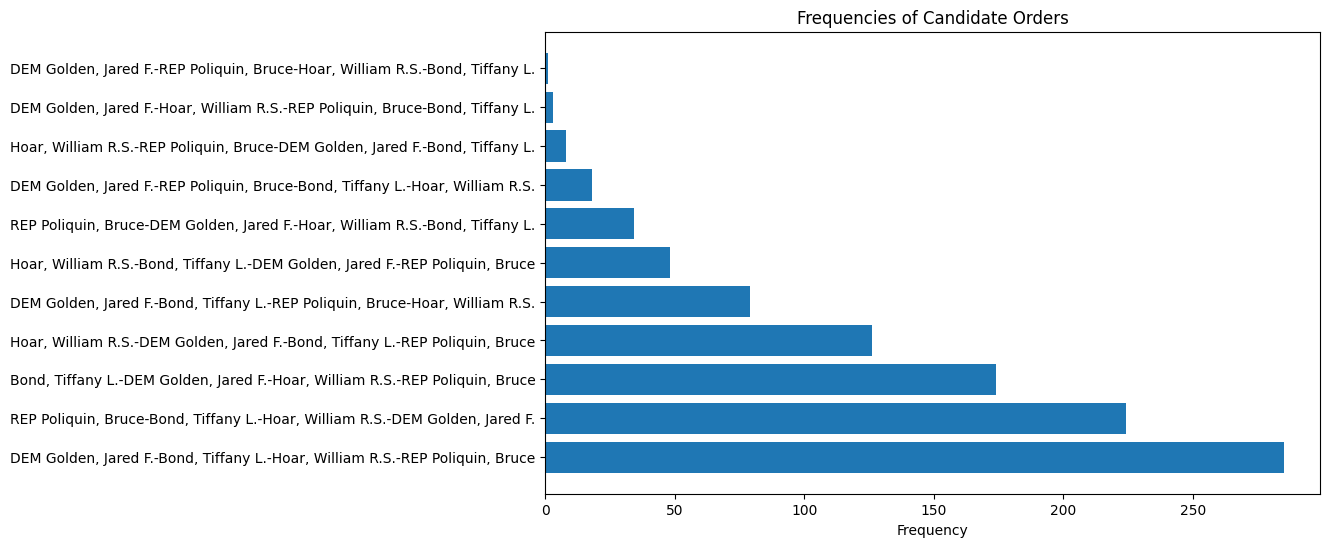

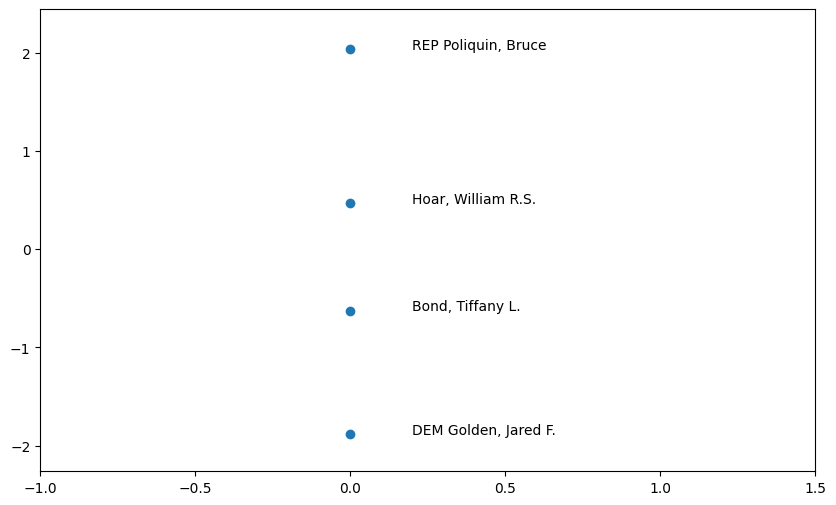

In [90]:
# Test the function with the provided CSV file
maine = perform_rcv_analysis(f"Maine_11062018_CongressionalDistrict2.csv", n_runs=1000)
avg_y_values_dict, most_common_order, all_order_frequencies, candidate_names = maine

# Call the plotting function
plot_rcv_analysis(avg_y_values_dict, most_common_order, all_order_frequencies, candidate_names)

/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_91856/280928822.py:81: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


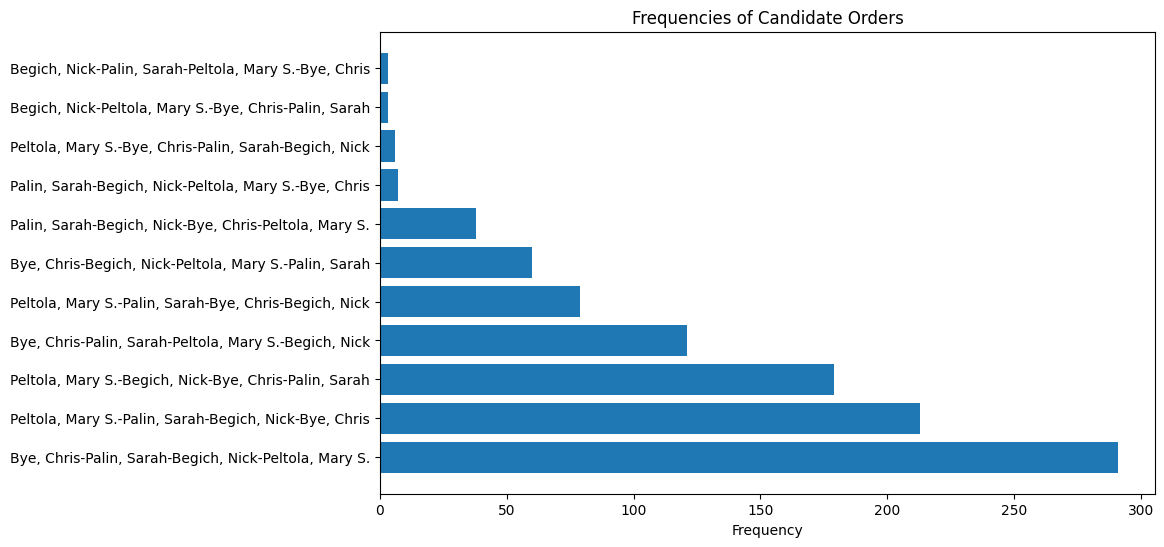

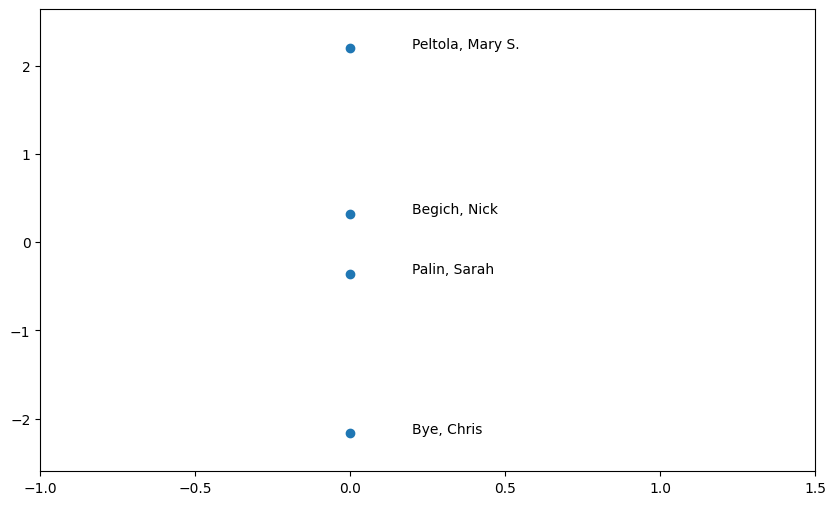

In [91]:
# Test the function with the provided CSV file
alaska = perform_rcv_analysis(f"Alaska_11082022_USRepresentative.csv", n_runs=1000)
avg_y_values_dict, most_common_order, all_order_frequencies, candidate_names = alaska

# Call the plotting function
plot_rcv_analysis(avg_y_values_dict, most_common_order, all_order_frequencies, candidate_names)

/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_91856/280928822.py:81: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


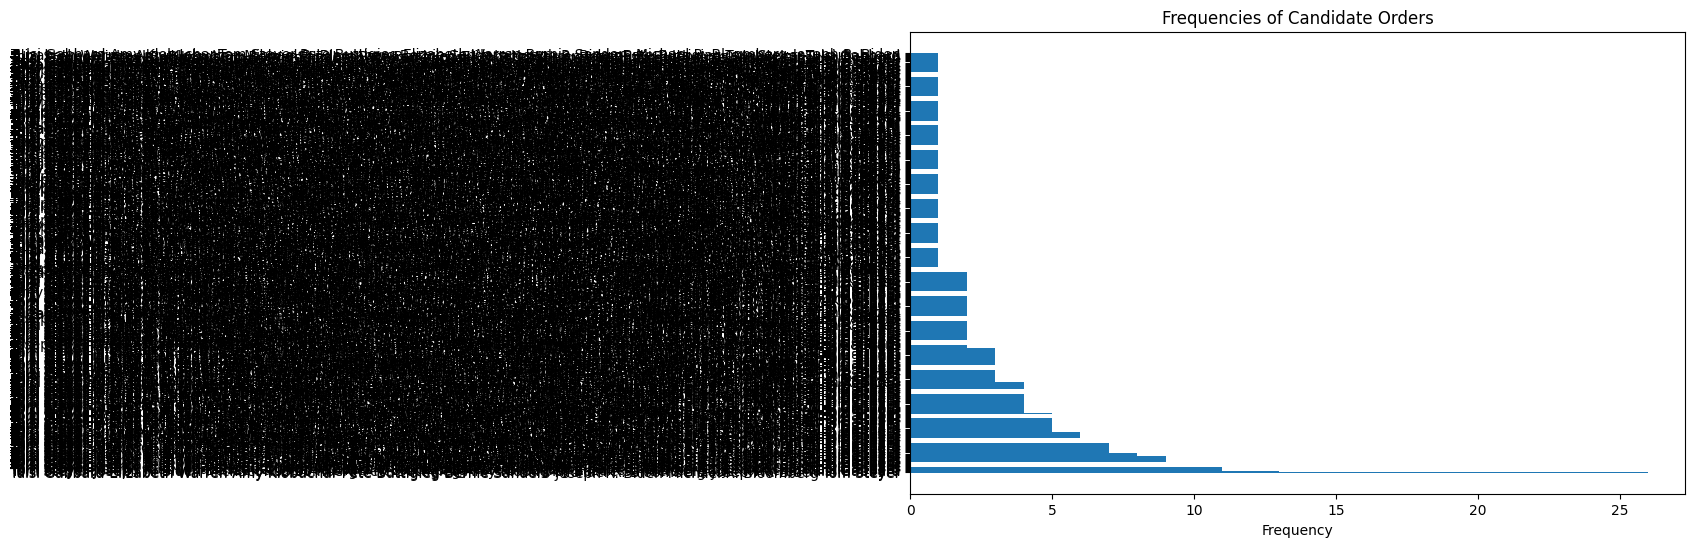

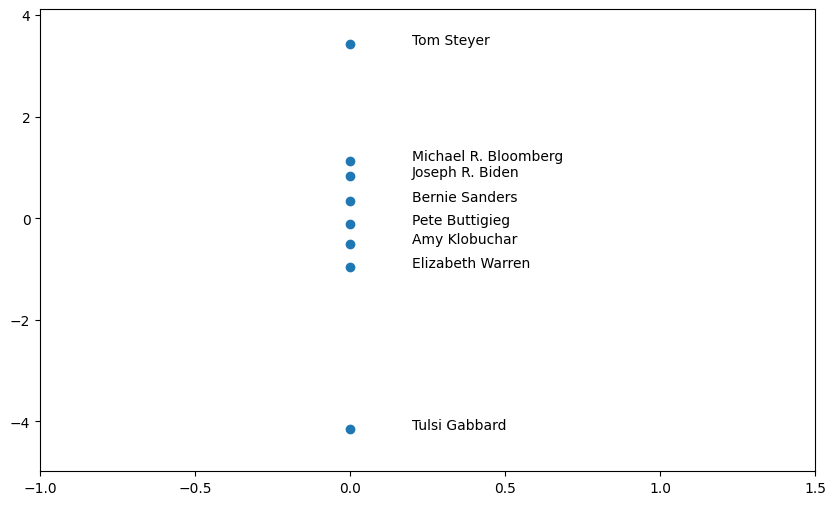

In [95]:
# Test the function with the provided CSV file
president = perform_rcv_analysis(f"Alaska_04102020_PRESIDENTOFTHEUNITEDSTATES.csv", n_runs=1000)
avg_y_values_dict, most_common_order, all_order_frequencies, candidate_names = president

# Call the plotting function
plot_rcv_analysis(avg_y_values_dict, most_common_order, all_order_frequencies, candidate_names)

/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_91856/280928822.py:81: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


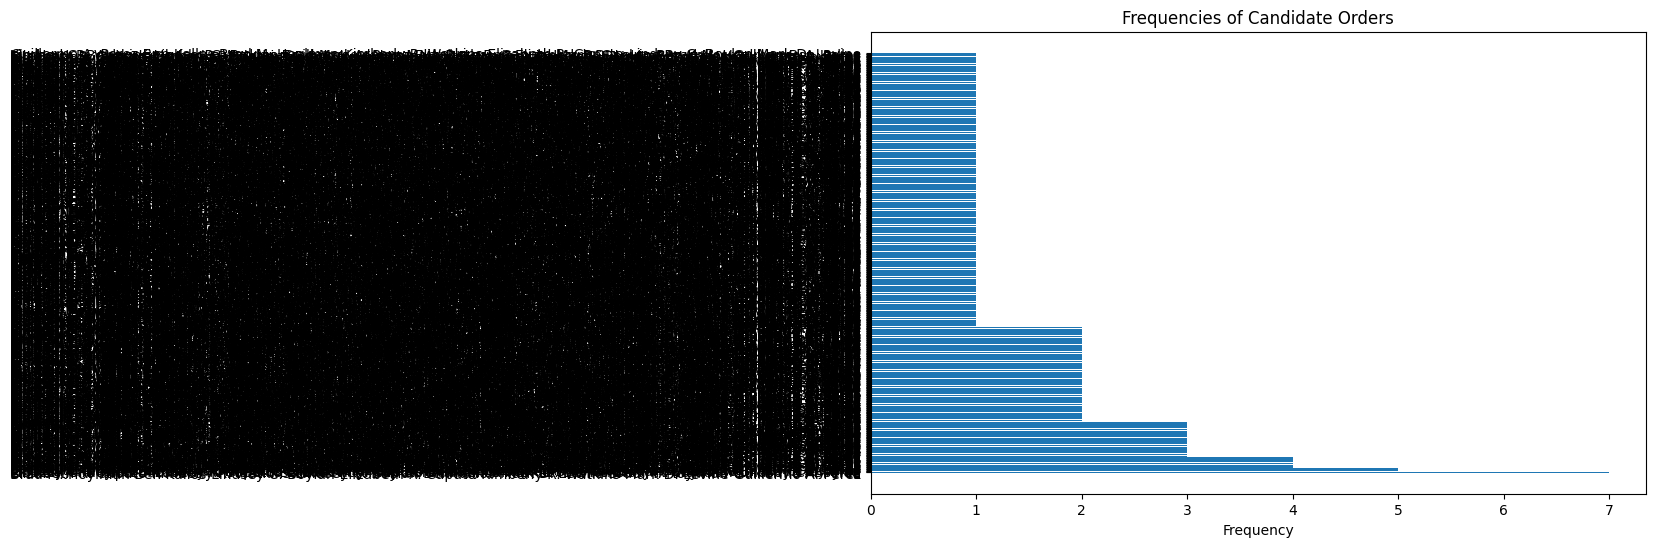

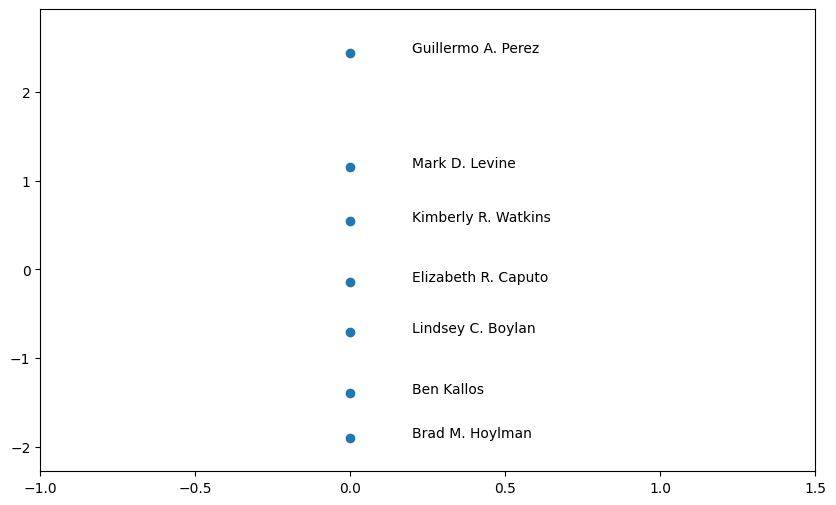

In [92]:
# Test the function with the provided CSV file
nyc = perform_rcv_analysis(f"NewYorkCity_06222021_DEMBoroughPresidentNewYork.csv", n_runs=1000)
avg_y_values_dict, most_common_order, all_order_frequencies, candidate_names = nyc

# Call the plotting function
plot_rcv_analysis(avg_y_values_dict, most_common_order, all_order_frequencies, candidate_names)

In [ ]:
import umap
from sklearn.preprocessing import OneHotEncoder

# Load the CSV file
df = pd.read_csv(f"Alaska_11082022_USRepresentative.csv")

# Filter out rows that do not have a candidate ranked first
ignore_values = ['skipped', 'overvote', 'writein','Write-in']
df = df[~df['rank1'].isin(ignore_values)]

# Create a list of all candidate names
candidate_names = pd.unique(df['rank1'])

# Perform one-hot encoding
encoder = OneHotEncoder(sparse=False, categories=[candidate_names])
ballots = encoder.fit_transform(df[['rank1']])

# Perform UMAP embedding
embedding = umap.UMAP().fit_transform(ballots)

# Plot the voting clusters
plt.scatter(embedding[:, 0], embedding[:, 1], s=1)

# Calculate and plot the mean position of each candidate
for i, candidate in enumerate(candidate_names):
    mean_position = embedding[df['rank1'] == candidate].mean(axis=0)
    plt.scatter(mean_position[0], mean_position[1])
    plt.text(mean_position[0], mean_position[1], candidate)

plt.show()

In [ ]:
from pyirt import irt

# Reshape your data to long format
# Each row should be a voter-candidate pair, with the voter ID, the candidate ID, and the rank
data_long = df.melt(id_vars='voter_id', var_name='candidate_id', value_name='rank')

# Fit the IRT model
item_param, user_param = irt(data_long['voter_id'], data_long['candidate_id'], data_long['rank'])

# Plot the estimated parameters
plt.scatter(user_param, [1]*len(user_param), label='Voters')
plt.scatter(item_param, [1]*len(item_param), label='Candidates')
plt.legend()
plt.show()